In [1]:
!pip -q install -U albumentations monai lightning

In [2]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split

import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.utilities.model_summary import ModelSummary

from torchvision.datasets import ImageFolder
from torchvision import models

from torchinfo import summary
from torchmetrics.classification import MulticlassConfusionMatrix,MulticlassAccuracy

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from datetime import timedelta

from monai.networks.nets import EfficientNetBN

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 0.0.19). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed_everything(42,workers = True)
device,count = ('cuda',torch.cuda.device_count()) if torch.cuda.is_available() else ('cpu',1)
print(device,count)

INFO: Seed set to 42


cuda 1


In [4]:
t = A.Compose([
    A.Resize(244,244),
#     A.CLAHE(always_apply = True),
    A.ToFloat(max_value = 255.0),
    ToTensorV2(),
])

def transform(im):
    return t(image = im)['image']

def loader(im_path):
    img = cv2.imread(im_path)
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [5]:
print('Making datasets')

train_ds = ImageFolder("/kaggle/input/cvc-dataprep/train/", transform = transform, loader = loader)
val_ds = test_ds = ImageFolder("/kaggle/input/cvc-dataprep/validation", transform = transform, loader = loader)

Making datasets


In [6]:
len(train_ds),len(val_ds),len(test_ds)

(15000, 16132, 16132)

In [7]:
c2i = train_ds.class_to_idx
i2c = {c2i[k]:k for k in c2i}

In [8]:
print('making dataloaders')

train_dl = DataLoader(train_ds, 16, shuffle = True,num_workers = 3,pin_memory = True )
val_dl = DataLoader(val_ds, 16,num_workers = 3, pin_memory = True)
test_dl = DataLoader(test_ds, 16,num_workers = 3,pin_memory = True)

making dataloaders


In [9]:
class CVCModel(L.LightningModule):
    def __init__(self,pretrained = True):
        super(CVCModel,self).__init__()
        
        self.model =  EfficientNetBN("efficientnet-b7",num_classes = len(c2i),pretrained=pretrained)
        self.model._fc = nn.Sequential(
                nn.LazyLinear(512),
                nn.PReLU(),
                nn.Dropout(0.3),
                nn.Linear(512,256),
                nn.PReLU(),
                nn.Dropout(0.3),
                # nn.Linear(256,10)
                nn.AdaptiveAvgPool1d(len(c2i))
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = MulticlassAccuracy(num_classes = 10, average = 'macro')
        self.val_acc = MulticlassAccuracy(num_classes=10, average = 'macro')
        self.test_acc = MulticlassAccuracy(num_classes = 10, average = None)
        self.test_confmat = MulticlassConfusionMatrix(num_classes = 10)

        self.example_input_array = [torch.rand((1,3,224,224), device = self.device)]
        
        self.save_hyperparameters()
        
    def forward(self,x):
        return self.model(x)

    def training_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self.forward(x)
        loss = self.loss_fn(y_pred,y)
        
        self.log('train_loss',loss,on_step=True,on_epoch=True,prog_bar=True,logger=True)
        self.train_acc.update(y_pred,y)
        
        return loss

    def validation_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self.forward(x)
        loss = self.loss_fn(y_pred,y)
        
        self.val_acc.update(y_pred,y)
        self.log('val_loss',loss,on_step=True,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def test_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self.forward(x)
        self.test_acc.update(y_pred,y)
        self.test_confmat.update(y_pred,y)
        
    def on_train_epoch_end(self):
#         if self.current_epoch == 0:
#             self.logger.experiment.add_graph(self,self.example_input_array)
            
        accuracy = self.train_acc.compute().item()
        self.log("train_accuracy",accuracy,on_step=False,on_epoch=True,prog_bar=True,logger=True)
        self.train_acc.reset()
    
    def on_validation_epoch_end(self):
        accuracy = self.val_acc.compute().item()
        self.log("val_accuracy",accuracy,on_step=False,on_epoch=True,prog_bar=True,logger=True)
        self.val_acc.reset()

    def on_test_epoch_start(self):
        self.val_acc.reset()
        self.test_confmat.reset()

    def on_test_epoch_end(self):
        accuracy = self.test_acc.compute()
        print("accuracy for this test: ", accuracy)
        
        
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters())
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,verbose = True)

        return {
            "optimizer":opt,
            "lr_scheduler":{
                "scheduler":sch,
                "monitor":"val_loss"
            }
        }

In [10]:
model = CVCModel()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 123MB/s]


In [11]:
summary(model.model,(64,3,244,244),depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNetBN                                     [64, 10]                  --
├─ConstantPad2d: 1-1                               [64, 3, 245, 245]         --
├─Conv2d: 1-2                                      [64, 64, 122, 122]        1,728
├─BatchNorm2d: 1-3                                 [64, 64, 122, 122]        128
├─MemoryEfficientSwish: 1-4                        [64, 64, 122, 122]        --
├─Sequential: 1-5                                  [64, 640, 7, 7]           --
│    └─Sequential: 2-1                             [64, 32, 122, 122]        10,920
│    └─Sequential: 2-2                             [64, 48, 61, 61]          253,424
│    └─Sequential: 2-3                             [64, 80, 30, 30]          716,068
│    └─Sequential: 2-4                             [64, 160, 15, 15]         3,721,660
│    └─Sequential: 2-5                             [64, 224, 15, 15]         7,615,904
│  

In [12]:
es_acc = EarlyStopping(monitor = "val_accuracy",mode="max",patience = 3)
# es_loss = EarlyStopping(monitor = "val_loss",mode = "min", patience = 5)
mc_acc = ModelCheckpoint(monitor = "val_accuracy",filename = "best_accuracy",mode = "max",save_weights_only = True)
mc_loss = ModelCheckpoint(monitor = "val_loss",filename = "best_loss",mode = "min",save_weights_only = True)

In [13]:
trainer = L.Trainer(
    max_epochs = 20,
    max_time = timedelta(hours = 10),
    default_root_dir = "./CVCModel",
    callbacks = [es_acc,mc_acc,mc_loss],
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model,train_dl,val_dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type                      | Params | Mode  | In sizes         | Out sizes
--------------------------------------------------------------------------------------------------
0 | model        | EfficientNetBN            | 65.2 M | train | [1, 3, 224, 224] | [1, 10]  
1 | loss_fn      | CrossEntropyLoss          | 0      | train | ?                | ?        
2 | train_acc    | MulticlassAccuracy        | 0      | train | ?                | ?        
3 | val_acc      | MulticlassAccuracy        | 0      | train | ?                | ?        
4 | test_acc     | MulticlassAccuracy        | 0      | train | ?                | ?        
5 | test_confmat | MulticlassConfusionMatrix | 0      | train | ?                | ?        
--------------------------------------------------------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.918   Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
trainer.test(model,test_dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

accuracy for this test:  tensor([0.5392, 0.4958, 0.8416, 0.0337, 0.6324, 0.6093, 0.9110, 0.6280, 0.7413,
        1.0000], device='cuda:0')


[{}]

In [16]:
test_acc = model.test_acc
confmat = model.test_confmat

In [17]:
confmat.compute()

tensor([[  268,     3,   191,     0,     0,     0,    26,     9,     0,     0],
        [    0,   178,   155,     0,     0,     0,     8,    18,     0,     0],
        [    6,     6,   972,     0,     2,     0,    77,    88,     3,     1],
        [    0,     0,   226,    10,     0,     0,    27,    34,     0,     0],
        [    0,     0,    49,     0,   215,     0,    56,    20,     0,     0],
        [    0,     0,    27,     0,     0,   209,    89,    18,     0,     0],
        [   31,    24,   501,     1,    23,    38, 11193,   476,     0,     0],
        [    0,     2,   124,     0,     0,     3,    57,   314,     0,     0],
        [    0,     0,    39,     0,     0,     1,     7,     0,   212,    27],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,    68]])

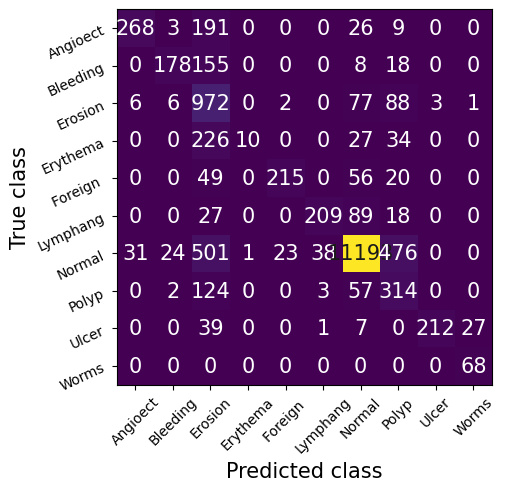

In [18]:
fig,ax = confmat.plot(labels = [v[0:8] for v in i2c.values()])

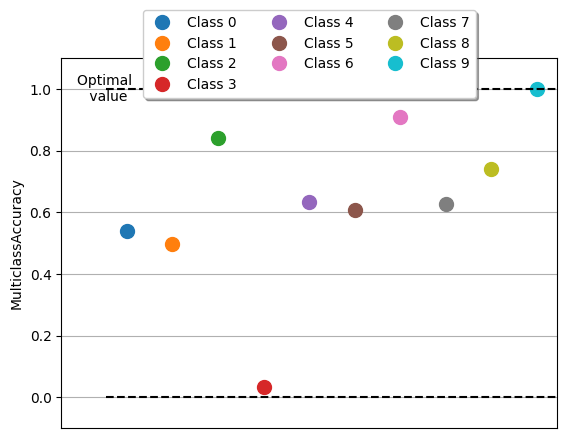

In [19]:
fig_,ax_ = test_acc.plot()

In [20]:
torch.save(model.state_dict(),"monai_effnetb7.pt")